In [1]:
import pandas as pd  #Read Data

def read_data(file_dir):
    df = pd.read_csv(file_dir)
    return df

In [2]:
import matplotlib.pyplot as plt

def visualize_data(df, col_name):
    one = 0
    zero = 0
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    for label in df[col_name]:
        if label == 1:
            one += 1
        else:
            zero += 1
    ax.bar(0.00, [one], color = 'g', width = 0.25)
    ax.bar(0.25, [zero], color = 'r', width = 0.25)

In [3]:
import string
from nltk import word_tokenize

replacers = {'sy':'saya','gak':'enggak','ssah':'susah','bgt':'banget','skrng':'sekarang','yg':'yang','gw':'gue',
             'baguuus':'bagus','mmbantu':'membantu', 'parahg':'parah'}

def words_normalization(sentence, dictionary):
    return " ".join([dictionary.get(w,w) for w in sentence.split()])

def preprocess1(text):
    case_folded = text.lower()
    exclude = set(string.punctuation + '1234567890')
    symbol_removed = ''.join(ch for ch in case_folded if ch not in exclude)
    word_normalized = words_normalization(symbol_removed, replacers)
    tokenized = word_tokenize(word_normalized)
    return tokenized

In [4]:
from nltk.tag import CRFTagger

def pos_tagging(data_ulasan):
    ct = CRFTagger()
    ct.set_model_file('all_indo_man_tag_corpus_model.crf.tagger')

    pos_ulasan = ct.tag_sents(data_ulasan)

    noun_data = list()
    for i,text in enumerate(pos_ulasan, start=0):
        temp = list()
        for term in text:
            if term[1] == 'VB' or term[1] == 'NN' or term[1] == 'JJ' or term[1] == 'RB':
                temp.append(term[0])
        noun_data.append(temp)

    pos_ulasan = data_ulasan

    for i in range(len(pos_ulasan)):
        pos_ulasan[i] = noun_data[i]
    
    return pos_ulasan

In [5]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer

def preprocess2(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stop = set(stopwords.words('indonesian'))
    text = TreebankWordDetokenizer().detokenize(text)
    
    stop_removed = ' '.join([word for word in text.split() if word not in stop])
    stemmed = ' '.join([stemmer.stem(word) for word in stop_removed.split()])
    tokenized = word_tokenize(stemmed)
    return tokenized

In [6]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 

def apply_oversampling(X, y):
    print('Original dataset shape %s' % Counter(y))
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res

In [7]:
#Convert label to negative 0 or positive 1
import numpy

def convert_sentiment_label(df, col_name):
    index_nan = list()
    df2 = df[['Ulasan', col_name]].copy()
    df2[col_name].replace(str("pos"), 1, inplace=True)
    df2[col_name].replace(str("neg"), 0, inplace=True)
    df2[col_name].replace("", float("NaN"), inplace=True)
    df2.dropna(subset=[col_name], inplace=True)
    df2[col_name] = df2[col_name].astype(numpy.int64)
    
    return df2

def convert_aspect_label(df, col_name):
    index_nan = list()
    df2 = df[['Ulasan', col_name]].copy()
    df2[col_name].replace(float("NaN"), 0, inplace=True)
    df2[col_name].replace(str("pos"), 1, inplace=True)
    df2[col_name].replace(str("neg"), 1, inplace=True)
    df2[col_name] = df2[col_name].astype(numpy.int64)
    
    return df2

In [8]:
import sklearn
from sklearn.model_selection import train_test_split

def split_data(df, col_name, test_size):
    words = df.Ulasan.tolist()
    label = df[col_name].tolist()
    x_train, x_test, y_train, y_test = train_test_split(words, label, test_size=test_size, random_state=10)
    return x_train, x_test, y_train, y_test

In [9]:
#https://stackoverflow.com/questions/53294482/how-to-get-tf-idf-scores-for-the-words

from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_vectorizer(x_train, x_test):
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5)
    vecx_train = vectorizer.fit_transform(x_train).toarray()
    vecx_test = vectorizer.transform(x_test).toarray()
    return vecx_train, vecx_test, vectorizer

In [57]:
from sklearn.naive_bayes import MultinomialNB
from time import time

def train_data_nb(x_train, y_train):
    t0 = time()
    model = MultinomialNB()
    model.fit(x_train, y_train)
    print(f"\nTraining time: {round(time()-t0, 3)}s")
    t0 = time()
    return model

In [58]:
from sklearn import svm

def train_data_svm(x_train, y_train):
    t0 = time()
    model = svm.SVC(kernel='linear')
    model.fit(x_train, y_train)
    print(f"\nTraining time: {round(time()-t0, 3)}s")
    t0 = time()
    return model

In [12]:
def predict_data(text, model):
    data = [text]
    vec_data = vectorizer.transform(data).toarray()
    return model.predict(vec_data)

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, vectorized_test_data, label):
    x_test = vectorized_test_data
    y_pred = model.predict(x_test)
    print(classification_report(label, y_pred))

In [67]:
from sklearn.model_selection import GridSearchCV

def grid_search_cv(X_train, y_train):
    # defining parameter range
    param_grid = {'C': [0.1, 1, 10], 
                  'gamma': [1, 0.1, 0.01],
                  'kernel': ['linear']} 
  
    grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
  
    # fitting the model for grid search
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    print(grid.best_estimator_)
    return grid

# Run Program!!!

In [33]:
#df = read_data("Data skripsi/fix hasil label/aspek_labeling_1.csv")
df = read_data("Data skripsi/dataset_ulasan_full.csv")

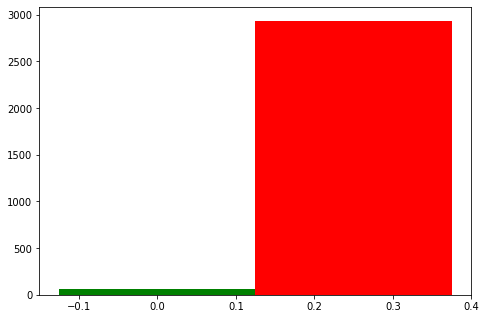

In [42]:
#aspects: 'Learnability', 'Efficiency', 'Memorability', 'Errors', 'Satisfaction'
#Pelabelan dengan 1 dan 0

col_name = 'Errors'
df_sentimen = convert_sentiment_label(df, col_name)
df_aspect = convert_aspect_label(df, col_name) 
visualize_data(df_sentimen, col_name)

In [43]:
#Split Data 

x_train1, x_test1, y_train1, y_test1 = split_data(df_aspect, col_name, test_size= 0.2) #Split Data untuk klasifikasi aspek
x_train2, x_test2, y_train2, y_test2 = split_data(df_sentimen, col_name, test_size= 0.2) #Split Data untuk klasifikasi sentimen

In [44]:
#Preprocessing 1

x_train1 = [preprocess1(text) for text in x_train1]
x_test1 = [preprocess1(text) for text in x_test1]

x_train2 = [preprocess1(text) for text in x_train2]
x_test2 = [preprocess1(text) for text in x_test2]

In [45]:
#Pos Tagging untuk data ulasan klasifikasi sentimen

x_train2 = pos_tagging(x_train2)
x_test2 = pos_tagging(x_test2)

In [46]:
#Preprocess 2

x_train1 = [preprocess2(text) for text in x_train1]
x_test1 = [preprocess2(text) for text in x_test1]

x_train2 = [preprocess2(text) for text in x_train2]
x_test2 = [preprocess2(text) for text in x_test2]

In [47]:
def detokenize(tokens):
    return TreebankWordDetokenizer().detokenize(tokens)

x_train1 = [detokenize(text) for text in x_train1]
x_test1 = [detokenize(text) for text in x_test1]

x_train2 = [detokenize(text) for text in x_train2]
x_test2 = [detokenize(text) for text in x_test2]

In [48]:
#Ekstraksi fitur TF-IDF

vx_train1, vx_test1, vectorizer1 = tfidf_vectorizer(x_train1, x_test1) #Untuk klasifikasi aspek
vx_train2, vx_test2, vectorizer2 = tfidf_vectorizer(x_train2, x_test2) #Untuk klasifikasi sentimen

In [49]:
#Oversampling

vx_train1, y_train1 = apply_oversampling(vx_train1, y_train1) #Oversampling data untuk klasifikasi aspek
print('----------------------------------------------------')
vx_train2, y_train2 = apply_oversampling(vx_train2, y_train2) ##Oversampling data untuk klasifikasi aspek

Original dataset shape Counter({1: 2383, 0: 650})
Resampled dataset shape Counter({1: 2383, 0: 2383})
----------------------------------------------------
Original dataset shape Counter({0: 2349, 1: 48})
Resampled dataset shape Counter({0: 2349, 1: 2349})


# Multi-NB

In [59]:
#Model Training Multi-NB

model_nb1 = train_data_nb(vx_train1, y_train1) #Training Model klasifikasi aspek 
print('--------------------------------------------------------')
model_nb2 = train_data_nb(vx_train2, y_train2) #Training Model klasifikasi sentimen


Training time: 0.087s
--------------------------------------------------------

Training time: 0.064s


In [51]:
print(evaluate_model(model_nb1, vx_test1, y_test1))
print('-----------------------------------------')
print(evaluate_model(model_nb2, vx_test2, y_test2))

              precision    recall  f1-score   support

           0       0.31      0.39      0.34       145
           1       0.85      0.79      0.82       614

    accuracy                           0.72       759
   macro avg       0.58      0.59      0.58       759
weighted avg       0.74      0.72      0.73       759

None
-----------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       590
           1       0.00      0.00      0.00        10

    accuracy                           0.90       600
   macro avg       0.49      0.46      0.47       600
weighted avg       0.97      0.90      0.93       600

None


# SVM

In [52]:
#Model Training SVM

model_svm1 = train_data_svm(vx_train1, vx_test1, y_train1, y_test1) #Training Model klasifikasi aspek 
print('----------------------------------------------------------')
model_svm2 = train_data_svm(vx_train2, vx_test2, y_train2, y_test2) #Training Model klasifikasi sentimen 



Training time: 53.104s
----------------------------------------------------------

Training time: 8.909s


In [53]:
print(evaluate_model(model_svm1, vx_test1, y_test1))
print('-----------------------------------------')
print(evaluate_model(model_svm2, vx_test2, y_test2))

              precision    recall  f1-score   support

           0       0.27      0.33      0.30       145
           1       0.83      0.79      0.81       614

    accuracy                           0.70       759
   macro avg       0.55      0.56      0.55       759
weighted avg       0.72      0.70      0.71       759

None
-----------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       590
           1       0.00      0.00      0.00        10

    accuracy                           0.98       600
   macro avg       0.49      0.50      0.49       600
weighted avg       0.97      0.98      0.97       600

None


# SVM with GridSearchCV

In [68]:
#Model Training SVM dengan GridSearchCV

grid_svm1 = grid_search_cv(vx_train1, y_train1) #Untuk Model klasifikasi aspek 

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.624 total time=  55.5s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.673 total time=  56.8s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.704 total time=  57.6s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.717 total time=  58.1s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.702 total time=  55.9s
[CV 1/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.624 total time=  55.5s
[CV 2/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.673 total time=  57.0s
[CV 3/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.704 total time=  56.9s
[CV 4/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.717 total time=  56.7s
[CV 5/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.702 total time=  57.1s
[CV 1/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.624 total time=  56.1s
[CV 2/5] END ..C=0.1, gamma=0.01, kernel=linear;,

In [ ]:
#grid_svm2 = grid_search_cv(vx_train2, y_train2) #Untuk Model klasifikasi sentimen 

In [69]:
print(evaluate_model(grid_svm1, vx_test1, y_test1))

              precision    recall  f1-score   support

           0       0.27      0.33      0.29       145
           1       0.83      0.78      0.81       614

    accuracy                           0.70       759
   macro avg       0.55      0.56      0.55       759
weighted avg       0.72      0.70      0.71       759

None


In [19]:
#SOurce: https://towardsdatascience.com/training-a-naive-bayes-model-to-identify-the-author-of-an-email-or-document-17dc85fa630a